In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..'); sys.path.append('../'); 

import numpy as np
import matplotlib.pyplot as plt
from setGame import *
import tensorflow as tf
import utils

In [2]:
setgame = SetGame()

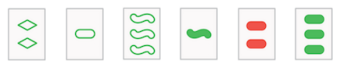

[3 4 5]


In [3]:
num_cards=6
_ = setgame.init_state(num_cards=num_cards, shuffle=False)
hand = setgame.state.dealt_cards
fig, axarr = plt.subplots(1, len(hand), figsize=(len(hand)*1,1))
pi = np.random.choice(range(len(hand)), size=len(hand), replace=False)
for i in range(len(hand)):
    card = hand[i]
    axarr[i].imshow(setgame.image_of_card(card[0], card[1]))
    axarr[i].axis('off')
plt.show()
print(np.sort(np.argsort(pi)[0:3]))


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split

class SetEmbedder():
    def __init__(self, ff_dim1=128, ff_dim2=64):
        img_input = layers.Input(shape=(70, 50, 4))
        x = layers.Conv2D(32, (5, 5), activation='relu')(img_input)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Conv2D(32, (5, 5), activation='relu')(x)
        x = layers.MaxPooling2D((4,4))(x)
        x = layers.Flatten()(x)
        x = layers.Dense(ff_dim1, activation='relu')(x)
        x = layers.Dense(ff_dim2, activation='tanh')(x)
        outputs = layers.Dense(12, activation='sigmoid')(x)
        self.model = Model(inputs=img_input, outputs=outputs)
        self.embed = Model(self.model.input, self.model.layers[7].output)
        self.model.summary()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        self.model_initial_weights = self.model.get_weights()

    def train(self, X_train, y_train, epochs=2):
        self.model.set_weights(self.model_initial_weights)
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    def predict(self, X_test):
        out = self.model.predict(X_test, verbose=0)
        return out

    def embed(self, X_test):
        out = self.embed(X_test, verbose=0)
        return out

In [5]:
def convert_to_binary(attrs):
    color = {'red':[1,0,0], 'green':[0,1,0], 'purple':[0,0,1]}
    pattern = {'empty':[1,0,0], 'striped':[0,1,0], 'solid':[0,0,1]}
    shape = {'diamond':[1,0,0], 'oval':[0,1,0], 'squiggle':[0,0,1]}
    number = {'one':[1,0,0], 'two':[0,1,0], 'three':[0,0,1]}
    binary_attrs = number[attrs[0]] + color[attrs[1]] + pattern[attrs[2]] + shape[attrs[3]]
    return binary_attrs

n = 1000
X = np.empty((n, 70, 50, 4), dtype=np.float32)
y = np.empty((n, 12), dtype=int)

card_coord = [(i,j) for i in np.arange(9) for j in np.arange(9)]
for i in np.arange(n):
    c = np.random.choice(np.arange(81), size=1)[0]
    (row, col) = card_coord[c]
    attrs = setgame.attributes_of_card(row, col)
    binary_attrs = convert_to_binary(attrs)
    X[i] = setgame.image_of_card(row, col)
    y[i] = binary_attrs


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
cnn = SetEmbedder(ff_dim1=64, ff_dim2=64)
cnn.train(X_train, y_train, epochs=15)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 70, 50, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 66, 46, 32)        3232      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 11, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 7, 32)         25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 96)                0     

In [7]:
for i in range(5):
    j = np.random.choice(range(X_test.shape[0]))
    pred = np.round(cnn.predict(X_test[j:(j+1)]))[0]
    pred = [int(pred[b]) for b in range(len(pred))]
    print(list(pred))
    print(list(y_test[j:(j+1)][0]))
    print('\n')

[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]


[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1]


[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]
[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]


[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]




In [8]:
def create_set_classification_dataset(num_seqs):

    vocab_size = 81
    setgame = SetGame()
    dim = len(cnn.embed(np.expand_dims(setgame.image_of_card(0, 0), axis=0)).numpy().squeeze())

    # generate random features for each object
    card_images = np.zeros((9, 9, dim))
    for i in range(9):
        for j in range(9):  
            card_images[i,j] = cnn.embed(np.expand_dims(setgame.image_of_card(i, j), axis=0)).numpy().squeeze()
            
    object_seqs = np.zeros((num_seqs, 3, dim))
    card_seqs = np.zeros((num_seqs, 3, 2), dtype=int)
    labels = np.zeros(num_seqs, dtype=int)

    for s in np.arange(0, num_seqs, 2):
        _ = setgame.init_state(num_cards=6, shuffle=False)
        hand = setgame.state.dealt_cards
        for i in np.arange(3):
            card = hand[i]
            object_seqs[s, i] = card_images[card[0], card[1]]
            card_seqs[s, i] = [card[0], card[1]]
        labels[s] = 1
        for i in np.arange(3):
            card = hand[i+3]
            object_seqs[s+1, i] = card_images[card[0], card[1]]
            card_seqs[s+1, i] = [card[0], card[1]]
        labels[s+1] = 0

    return card_images, card_seqs, labels, object_seqs,

In [9]:
card_images, card_seqs, labels, object_seqs = create_set_classification_dataset(num_seqs=10000)

In [10]:
test_size = 0.2
val_size = 0.1

seqs_train, seqs_test, object_seqs_train, object_seqs_test, labels_train, labels_test = train_test_split(card_seqs, object_seqs, labels, test_size=0.2)

seqs_train, seqs_val, object_seqs_train, object_seqs_val, labels_train, labels_val = \
train_test_split(seqs_train, object_seqs_train, labels_train, test_size=val_size/(1-test_size))

source_train, source_val, source_test = object_seqs_train, object_seqs_val, object_seqs_test


In [11]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, name='binary_crossentropy')
create_opt = lambda : tf.keras.optimizers.Adam()


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from transformer_modules import Encoder, Decoder, AddPositionalEmbedding
from abstracters import SymbolicAbstracter, RelationalAbstracter

class TransformerClassifier(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab, embedding_dim, 
            dropout_rate=0.1, name='transformer_classifier'):
        """A transformer model.

        Args:
            num_layers (int): # of layers in encoder and decoder
            num_heads (int): # of attention heads in attention operations
            dff (int): dimension of feedforward laeyrs
            input_vocab (int or str): if input is tokens, the size of vocabulary as an int. 
                if input is vectors, the string 'vector'. used to create embedder.
            embedding_dim (int): embedding dimension to use. this is the model dimension.
            dropout_rate (float, optional): dropout rate. Defaults to 0.1.
            name (str, optional): name of model. Defaults to 'transformer'.
        """

        super().__init__(name=name)

        if isinstance(input_vocab, int):
            self.source_embedder = layers.Embedding(input_vocab, embedding_dim, name='source_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.flattener = layers.Flatten()
        self.final_layer = layers.Dense(2, name='final_layer')


    def call(self, inputs):
        source = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)
        encoder_context = self.encoder(x)
        output = self.flattener(encoder_context)
        logits = self.final_layer(output)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        return logits



In [13]:
transformer_model = TransformerClassifier(
    num_layers=2, num_heads=4, dff=64, 
    input_vocab='vector', embedding_dim=64)

transformer_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
transformer_model(object_seqs_train[:32])
transformer_model.summary()

Model: "transformer_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 4160      
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           multiple                  149888    
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 final_layer (Dense)         multiple                  386       
                                                                 
Total params: 154,434
Trainable params: 154,

In [14]:
train_size = 1000
X_train = source_train[:train_size]
y_train = labels_train[:train_size]
X_val = source_val
y_val = labels_val
history = transformer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
32/32 [==============================] - 4s 26ms/step - loss: 0.8161 - acc: 0.5540 - val_loss: 0.7192 - val_acc: 0.5420
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 0.7003 - acc: 0.5760 - val_loss: 0.6913 - val_acc: 0.5620
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 0.6384 - acc: 0.6160 - val_loss: 0.7005 - val_acc: 0.5750
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6131 - acc: 0.6580 - val_loss: 0.6602 - val_acc: 0.6310
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.5721 - acc: 0.7030 - val_loss: 0.6315 - val_acc: 0.6630
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.4821 - acc: 0.7640 - val_loss: 0.5578 - val_acc: 0.7260
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.4386 - acc: 0.7890 - val_loss: 0.5586 - val_acc: 0.7170
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.4180 - a

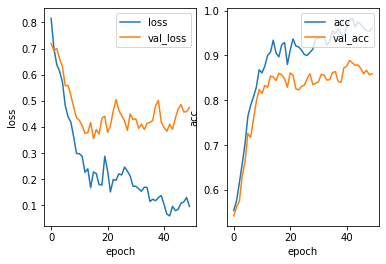

In [15]:
utils.plot_history(history, ('loss', 'acc'));


In [16]:
out = transformer_model.predict(source_test, verbose=0)
yhat = np.argmax(out, axis=1)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==labels_test)))


test accuracy: 85.70%



In [17]:
class AbstractorClassifier(tf.keras.Model):
    def __init__(self, num_layers, num_heads, dff,
            input_vocab, embedding_dim, dropout_rate=0.1, name='abstractor_classifier'):
        """
        Sequenc Relational Abstractor.

        Args:
            num_layers (int): # of layers in encoder and decoder
            num_heads (int): # of attention heads in attention operations
            dff (int): dimension of feedforward laeyrs
            input_vocab (int or str): if input is tokens, the size of vocabulary as an int. 
                if input is vectors, the string 'vector'. used to create embedder.
            embedding_dim (int): embedding dimension to use. this is the model dimension.
            dropout_rate (float, optional): dropout rate. Defaults to 0.1.
            name (str, optional): name of model. Defaults to 'seq2seq_relational_abstracter'.
        """

        super().__init__(name=name)

        if isinstance(input_vocab, int):
            self.source_embedder = layers.Embedding(input_vocab, embedding_dim, name='source_embedder')
        elif input_vocab == 'vector':
            self.source_embedder = layers.TimeDistributed(layers.Dense(embedding_dim), name='source_embedder')
        else:
            raise ValueError(
                "`input_vocab` must be an integer if the input sequence is token-valued or "
                "'vector' if the input sequence is vector-valued.")

        self.pos_embedding_adder_input = AddPositionalEmbedding(name='add_pos_embedding_input')
        self.encoder = Encoder(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='encoder')
        self.abstractor = RelationalAbstracter(num_layers=num_layers, num_heads=num_heads, dff=dff, dropout_rate=dropout_rate, name='abstractor')
        self.flattener = layers.Flatten()
        self.final_layer = layers.Dense(2, name='final_layer')


    def call(self, inputs):
        source = inputs

        x = self.source_embedder(source)
        x = self.pos_embedding_adder_input(x)
        encoder_context = self.encoder(x)
        abstracted_context = self.abstractor(encoder_context)
        outputs = self.flattener(abstracted_context)
        logits = self.final_layer(outputs)

        try:
          # Drop the keras mask, so it doesn't scale the losses/metrics.
          # b/250038731
          del logits._keras_mask
        except AttributeError:
          pass

        return logits



In [22]:
abstractor_model = AbstractorClassifier(
    num_layers=2, num_heads=2, dff=64, 
    input_vocab='vector', embedding_dim=64)

abstractor_model.compile(loss=loss, optimizer=create_opt(), metrics=['acc'])
abstractor_model(X_train[:32])
abstractor_model.summary()

Model: "abstractor_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 source_embedder (TimeDistri  multiple                 4160      
 buted)                                                          
                                                                 
 add_pos_embedding_input (Ad  multiple                 0         
 dPositionalEmbedding)                                           
                                                                 
 encoder (Encoder)           multiple                  83584     
                                                                 
 abstractor (RelationalAbstr  multiple                 150464    
 acter)                                                          
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                             

In [23]:
train_size = 1000
X_train = source_train[:train_size]
y_train = labels_train[:train_size]
X_val = source_val
y_val = labels_val
history = abstractor_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50
32/32 [==============================] - 10s 48ms/step - loss: 0.8576 - acc: 0.4950 - val_loss: 0.6922 - val_acc: 0.5130
Epoch 2/50
32/32 [==============================] - 1s 21ms/step - loss: 0.7395 - acc: 0.5140 - val_loss: 0.6960 - val_acc: 0.5160
Epoch 3/50
32/32 [==============================] - 1s 21ms/step - loss: 0.7084 - acc: 0.5350 - val_loss: 0.6707 - val_acc: 0.5800
Epoch 4/50
32/32 [==============================] - 1s 23ms/step - loss: 0.6570 - acc: 0.6160 - val_loss: 0.7368 - val_acc: 0.5490
Epoch 5/50
32/32 [==============================] - 1s 20ms/step - loss: 0.6709 - acc: 0.5840 - val_loss: 0.7320 - val_acc: 0.5290
Epoch 6/50
32/32 [==============================] - 1s 19ms/step - loss: 0.6264 - acc: 0.6510 - val_loss: 0.6180 - val_acc: 0.6730
Epoch 7/50
32/32 [==============================] - 1s 19ms/step - loss: 0.5640 - acc: 0.7160 - val_loss: 0.5400 - val_acc: 0.7080
Epoch 8/50
32/32 [==============================] - 1s 19ms/step - loss: 0.5228 - 

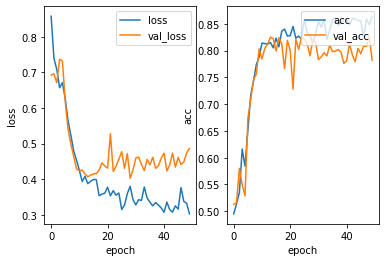

In [24]:
utils.plot_history(history, ('loss', 'acc'));


In [25]:
out = abstractor_model.predict(source_test, verbose=0)
yhat = np.argmax(out, axis=1)
print('test accuracy: %.2f%%\n' % (100*np.mean(yhat==labels_test)))


test accuracy: 80.05%

